<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "NonN"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level2-MajorCellType/NonN/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


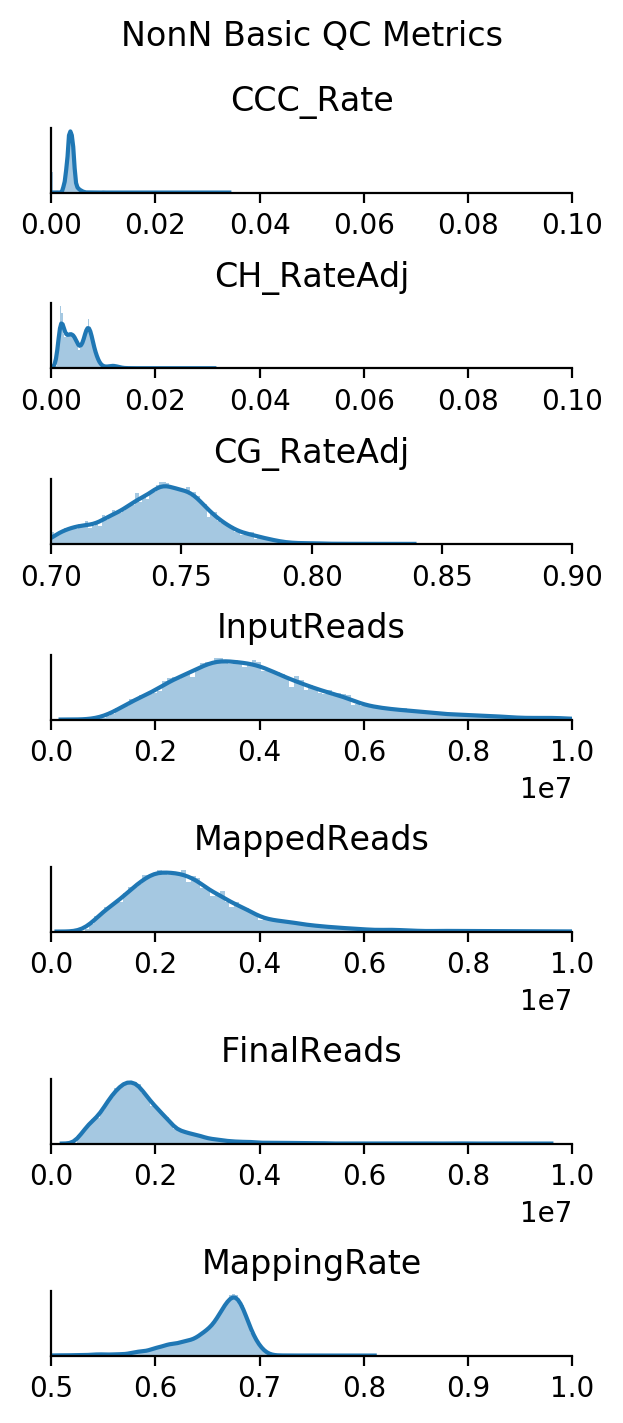

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

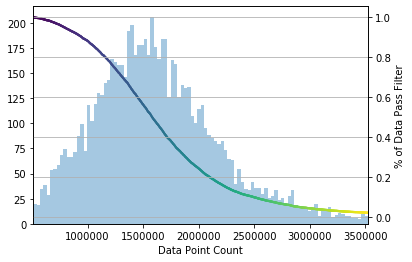

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 7920/7920 (100.0%)
CG_RateAdj passed 7920/7920 (100.0%)
CH_RateAdj passed 7920/7920 (100.0%)
FinalReads passed 7920/7920 (100.0%)
MappingRate passed 7920/7920 (100.0%)
Overall passed 7920/7920 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 79
171207 73
171212 24
171213 69
171214 73
171219 103
180104 42
180109 95
180110 94
180111 68
180119 106
180122 34
180123 68
180129 26
180130 34
180205 41
180206 64
180208 90
180212 156
180213 72
180220 81
180222 80
180226 62
180227 68
180305 63
180306 73
180312 64
180313 33
180319 20
180320 101
180326 101
180329 94
180402 66
180403 110
180405 67
180409 77
180410 59
180412 103
180416 79
180417 84
180419 74
180423 96
180424 57
180426 95
180430 95
180501 78
180514 59
180529 77
180605 2
180724 7
180806 57
180911 82
180917 43
180925 113
181002 86
181008 127
181009 155
181015 133
181016 123
181022 118
181023 116
181204 99
181206 205
181210 92
181218 61
181220 159
190108 107
190117 115
190122 135
190124 102
190131 95
190205 217
190207 124
190212 208
190214 265
190219 226
190305 186
190307 98
190625 65
190627 122
190711 306
190716 244


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 964 251.0%
ad002 993 258.6%
ad004 1019 265.4%
ad006 981 255.5%
ad007 1020 265.6%
ad008 973 253.4%
ad010 1001 260.7%
ad012 969 252.3%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,MappingRate,Pos96,Plate,Col96,Row96,Col384,Row384,FACS_Date,Slice,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
10E_M_116,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004406,0.745677,0.744551,0.012093,0.007720,1352223.0,3406212,2175142.0,10E,...,0.638581,B12,CEMBA190625-10E-1,11,1,22,2,190625,10,True
10E_M_117,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.003866,0.649548,0.648188,0.006675,0.002820,1647058.0,4158780,2705736.0,10E,...,0.650608,B12,CEMBA190625-10E-1,11,1,22,3,190625,10,True
10E_M_118,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004403,0.741310,0.740166,0.011342,0.006970,1288597.0,3384916,2114331.0,10E,...,0.624633,B12,CEMBA190625-10E-1,11,1,23,2,190625,10,True
10E_M_119,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004510,0.757342,0.756242,0.011958,0.007482,1539349.0,3958192,2505673.0,10E,...,0.633035,B12,CEMBA190625-10E-1,11,1,23,3,190625,10,True
10E_M_120,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004477,0.746806,0.745667,0.012476,0.008035,1909841.0,4821680,3145700.0,10E,...,0.652407,B12,CEMBA190625-10E-2,11,1,22,2,190625,10,True
10E_M_121,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004216,0.739956,0.738855,0.010591,0.006401,1387404.0,3690756,2263809.0,10E,...,0.613373,B12,CEMBA190625-10E-2,11,1,22,3,190625,10,True
10E_M_1341,/gale/raidix/rdx-4/mapping/10E/CEMBA190625-10E...,0.004295,0.756914,0.755865,0.011942,0.007680,1334663.0,3401216,2237085.0,10E,...,0.657731,G12,CEMBA190625-10E-3,11,6,22,12,190625,10,True
10E_M_1532,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003855,0.740866,0.739863,0.009733,0.005901,789983.0,2570252,1457407.0,10E,...,0.567029,A12,CEMBA190627-10E-1,11,0,22,1,190627,10,True
10E_M_1533,/gale/raidix/rdx-4/mapping/10E/CEMBA190627-10E...,0.003984,0.726839,0.725746,0.009587,0.005625,2103584.0,6048324,3813800.0,10E,...,0.630555,A12,CEMBA190627-10E-1,11,0,23,0,190627,10,True
